In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from tqdm import tqdm
import os
import pandas as pd
import requests

In [ ]:
import seaborn as sns
sns.set_theme()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Data

## Read metadata from disk

In [ ]:
station_names = ['Hauptbahnhof', 'Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']

In [ ]:
data_dir = '/content/drive/MyDrive/University of Stuttgart/AACV/data'

In [ ]:
os.listdir(data_dir)

['Anna', 'Beate', 'Berkay']

In [ ]:
df = []
file_types = ['raw']  # raw, processed
st_name_vis_options = ['st_name', 'no_st_name']  # station name visibility

for author in os.listdir(data_dir):
  for file_type in file_types:
    for station in station_names:
      for st_name_vis in st_name_vis_options:
        for f in os.listdir(f'{data_dir}/{author}/{file_type}/{station}/{st_name_vis}'):
          df.append((station, author, file_type, st_name_vis, f,
                     f'{author}/{file_type}/{station}/{st_name_vis}/{f}'))

df = pd.DataFrame(df, columns=['station', 'author', 'file_type',
                               'st_name_visible', 'filename', 'file_path'])

# ensures correct order of appearance in plots
df['station'] = pd.Categorical(df['station'], ordered=True,
                categories=['Hauptbahnhof', 'Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University'])

df['st_name_visible'] = df['st_name_visible'].replace({'st_name': True, 'no_st_name': False})
df['st_name_visible'] = pd.Categorical(df['st_name_visible'], ordered=True, categories=[True, False])

df.head()

/tmp/ipython-input-8-3881505212.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['st_name_visible'] = df['st_name_visible'].replace({'st_name': True, 'no_st_name': False})


,station,author,file_type,st_name_visible,filename,file_path
0,Stadtmitte,Anna,raw,True,20250513_132112.jpg,Anna/raw/Stadtmitte/st_name/20250513_132112.jpg
1,Stadtmitte,Anna,raw,True,20250512_132302.jpg,Anna/raw/Stadtmitte/st_name/20250512_132302.jpg
2,Stadtmitte,Anna,raw,True,20250512_132259.jpg,Anna/raw/Stadtmitte/st_name/20250512_132259.jpg
3,Stadtmitte,Anna,raw,True,20250512_132258.jpg,Anna/raw/Stadtmitte/st_name/20250512_132258.jpg
4,Stadtmitte,Anna,raw,True,20250512_132243.jpg,Anna/raw/Stadtmitte/st_name/20250512_132243.jpg


In [ ]:
df.shape

(216, 6)

# Keep correctly labeled images

In [ ]:
df = df[df['station'].isin(station_names)]
df.shape

(216, 6)

# Station (target) distribution

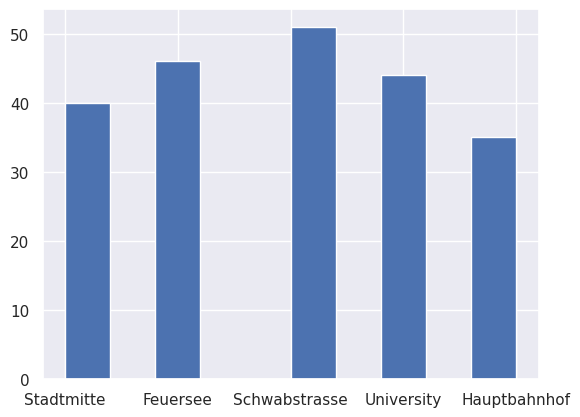

In [ ]:
df['station'].hist();

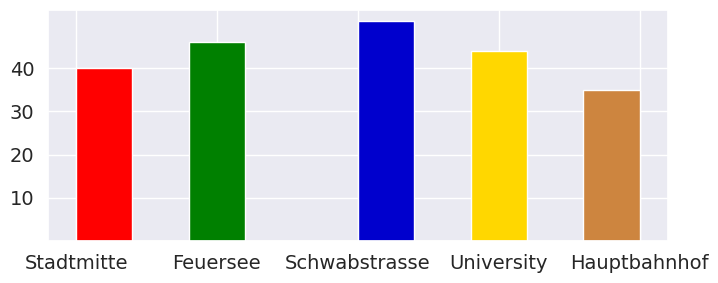

In [ ]:
ax = df['station'].hist(figsize=(8, 3))
ax.patches[0].set_facecolor('red')      # hauptbahnhof
ax.patches[2].set_facecolor('green')    # stadtmitte
ax.patches[5].set_facecolor('mediumblue')     # feuersee
ax.patches[7].set_facecolor('gold')     # schwabstrasse
ax.patches[9].set_facecolor('peru')     # university
ax.tick_params(labelsize=14);
ax.set_yticks([0, 10, 20, 30, 40], ['', 10, 20, 30, 40]);

# Station name visibility

In [ ]:
df['st_name_visible'].value_counts()

,count
st_name_visible,
True,115
False,101


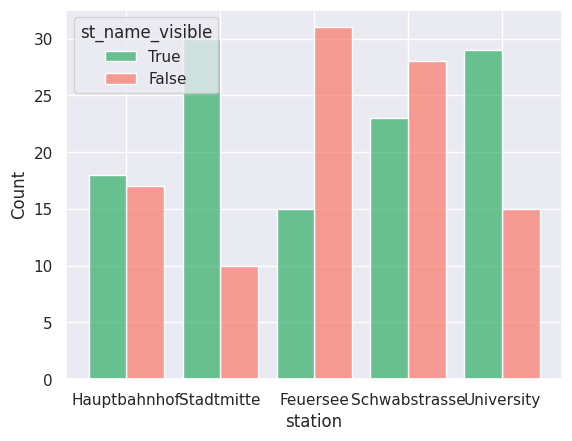

In [ ]:
sns.histplot(data=df.sort_values(by='st_name_visible', ascending=False),
             x='station', hue='st_name_visible', multiple="dodge", shrink=.8,
             palette=['mediumseagreen', 'salmon']);

# Filter data

In [ ]:
# drop Hauptbahnhof
# df = df[df['station'] != 'Hauptbahnhof']
df.shape

(216, 6)

Split randomly into train / val / test set

In [ ]:
# train / val / test -- 0.7 / 0.1 / 0.2
test_size, val_size = round(df.shape[0] * 0.2), round(df.shape[0] * 0.1)

In [ ]:
df_train, df_test = train_test_split(df, test_size=test_size)
df_train, df_val = train_test_split(df_train, test_size=val_size)

## Read dataset (hard split)

In [ ]:
# 4 classes
station_names = ['Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']

# 5 classes
# station_names = ['Hauptbahnhof', 'Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']

In [ ]:
ds_version = '4'  # 4 classes w/o Hbf
data_dir = f'/content/drive/MyDrive/University of Stuttgart/AACV/dataset/dataset_{ds_version}'
data_dir

'/content/drive/MyDrive/University of Stuttgart/AACV/dataset/dataset_4'

In [ ]:
df_train = pd.read_csv(f'{data_dir}/train/df_train.csv')
df_val = pd.read_csv(f'{data_dir}/val/df_val.csv')
df_test = pd.read_csv(f'{data_dir}/test/df_test.csv')

print('Train:', df_train.shape[0])
print('Val:', df_val.shape[0])
print('Test:', df_test.shape[0])

Train: 127
Val: 18
Test: 36


In [ ]:
from google import genai

api_key = "YOUR_API_KEY"  # replace with your actual API key


client = genai.Client(api_key=api_key)

#Prompt
Look at this image and tell me which of these train stations it is from: {', '.join(station_names)}.
          Here are some key visual attributes for each station that might help you identify it:
          Feuersee: Dark Purple / Violet wall behind the station name.
          Schwabstrasse: Yellowish-Green / Chartreuse tiled wall, possibly with geometric patterns.
          Stadtmitte: Medium to dark Green wall, possibly with horizontal banding.
          University: Light Brown / Terracotta / Orangey-Brown glossy panels on the walls and similar colored floor tiles.
          Respond only with the station name.


In [ ]:

def guess_station(file_path, station_names):
    try:
        # Upload the file using genai.upload_file()
        uploaded_file = client.files.upload(file=file_path)

        # Use genai to generate content from the image and a prompt

        prompt = f"""Look at this image and tell me which of these train stations it is from: {', '.join(station_names)}.
          Here are some key visual attributes for each station that might help you identify it:
          Hauptbahnhof: Red / Dark-Red / Reddish-Orange wall behind the station name.
          Feuersee: Dark Purple / Violet wall behind the station name.
          Schwabstrasse: Yellowish-Green / Chartreuse tiled wall, possibly with geometric patterns.
          Stadtmitte: Medium to dark Green wall, possibly with horizontal banding.
          University: Light Brown / Terracotta / Orangey-Brown glossy panels on the walls and similar colored floor tiles.
          Respond only with the station name.
          """
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=[uploaded_file, prompt],  # Use the uploaded file object
        )
        # Possible models to try out and compare the results:
        # gemini-2.0-flash
        # gemini-2.5-flash-preview-05-20
        # gemini-2.5-flash

        # Extract the generated text (the guessed station name)
        guessed_station = response.text.strip()

        # Delete the uploaded file after use (optional but recommended)
        #client.files.delete(uploaded_file.name)


        return guessed_station
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred for {file_path}: {e}")
        return None


# Zero-Shot

In [ ]:
'''
def guess_station(file_path, station_names):
    try:
        # Upload the file using genai.upload_file()
        uploaded_file = client.files.upload(file=file_path)

        # Use genai to generate content from the image and a prompt
        prompt = f"""Look at this image and tell me which of these train stations it is from: {', '.join(station_names)}.
          Respond only with the station name.
          """
        response = client.models.generate_content(
            model="gemini-2.0-flash",
            contents=[uploaded_file, prompt],  # Use the uploaded file object
        )
        # Possible models to try out and compare the results:
        # gemini-2.0-flash
        # gemini-2.5-flash-preview-05-20
        # gemini-2.5-flash

        # Extract the generated text (the guessed station name)
        guessed_station = response.text.strip()

        # Delete the uploaded file after use (optional but recommended)
        #client.files.delete(uploaded_file.name)


        return guessed_station
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None
    except Exception as e:
        print(f"An unexpected error occurred for {file_path}: {e}")
        return None

'''

In [ ]:
# Example usage with the full file path:
# data_dir = '/content/drive/MyDrive/AACV/data' # Make sure data_dir is defined
stations_to_guess = ['Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']

# Add a new column 'guessed_station' to the DataFrame
df_test['guessed_station'] = None

# Loop through each row in the dataframe and populate the 'guessed_station' column
for index, row in df_test.iterrows():
  full_file_path = os.path.join(data_dir, row['file_path'])
  guessed = guess_station(full_file_path, stations_to_guess)
  df_test.at[index, 'guessed_station'] = guessed

# Calculate accuracy
correct_guesses = (df_test['station'] == df_test['guessed_station']).sum()
accuracy = correct_guesses / len(df_test)

print(f"Accuracy: {accuracy}")

Accuracy: 0.7441860465116279


In [ ]:
df_test.head()

,station,author,file_type,st_name_visible,filename,file_path,guessed_station
0,Hauptbahnhof,Berkay,raw,True,IMG_6867.HEIC,test/images/IMG_6867.HEIC,Hauptbahnhof
1,Hauptbahnhof,Berkay,raw,True,5ebb528e-7525-4ec2-96fe-53a426c7f50f.jpg,test/images/5ebb528e-7525-4ec2-96fe-53a426c7f5...,Hauptbahnhof
2,Stadtmitte,Berkay,raw,True,IMG_6576.HEIC,test/images/IMG_6576.HEIC,Stadtmitte
3,Hauptbahnhof,Berkay,raw,True,1468dd07-54f5-4e5f-8830-1a7aca5ba146.jpg,test/images/1468dd07-54f5-4e5f-8830-1a7aca5ba1...,Hauptbahnhof
4,Schwabstrasse,Anna,raw,True,20250506_111516.jpg,test/images/20250506_111516.jpg,Schwabstrasse


In [ ]:
# Calculate the F1 score
f1 = f1_score(df_test['station'], df_test['guessed_station'], average='macro')

print(f"F1 Score (macro): {f1}")

F1 Score (macro): 0.6239567621920563


In [ ]:
# prompt: provide me important details about df_random

print("\nShape of df_random:", df_random.shape)
print("\nData types of df_random columns:\n", df_random.dtypes)
print("\nValue counts for 'station' in df_random:\n", df_random['station'].value_counts())
print("\nValue counts for 'random_guess' in df_random:\n", df_random['random_guess'].value_counts())


Shape of df_random: (43, 8)

Data types of df_random columns:
 station            object
author             object
file_type          object
st_name_visible      bool
filename           object
file_path          object
guessed_station    object
random_guess       object
dtype: object

Value counts for 'station' in df_random:
 station
Stadtmitte       11
Feuersee         10
University        8
Hauptbahnhof      7
Schwabstrasse     7
Name: count, dtype: int64

Value counts for 'random_guess' in df_random:
 random_guess
Schwabstrasse    10
Stadtmitte        9
University        9
Feuersee          8
Hauptbahnhof      7
Name: count, dtype: int64


# Street Name Visible and Masked Section

In [ ]:
df_test_st_name = pd.read_csv(
    f'{data_dir}/test_st_name/st_name_visible/df_test_st_name_visible.csv')
df_test_mask = pd.read_csv(
    f'{data_dir}/test_st_name/st_name_masked/df_test_st_name_masked.csv')
print('Test st. name visible:', df_test_st_name.shape[0])
print('Test st. name masked:', df_test_mask.shape[0])

Test st. name visible: 20
Test st. name masked: 20


In [ ]:
# Example usage with the full file path:
# data_dir = '/content/drive/MyDrive/AACV/data' # Make sure data_dir is defined
stations_to_guess = ['Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']

# Add a new column 'guessed_station' to the DataFrame
df_test_st_name['guessed_station'] = None

# Loop through each row in the dataframe and populate the 'guessed_station' column
for index, row in df_test_st_name.iterrows():
  full_file_path = os.path.join(data_dir, row['file_path'])
  guessed = guess_station(full_file_path, stations_to_guess)
  df_test_st_name.at[index, 'guessed_station'] = guessed

# Calculate accuracy
correct_guesses = (df_test_st_name['station'] == df_test_st_name['guessed_station']).sum()
accuracy = correct_guesses / len(df_test_st_name)

# Calculate the F1 score
f1 = f1_score(df_test_st_name['station'], df_test_st_name['guessed_station'], average='macro')

print(f"For street name visible:")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (macro): {f1}")

For street name visible:
Accuracy: 0.75
F1 Score (macro): 0.7388888888888889


In [ ]:
# Example usage with the full file path:
# data_dir = '/content/drive/MyDrive/AACV/data' # Make sure data_dir is defined
stations_to_guess = ['Stadtmitte', 'Feuersee', 'Schwabstrasse', 'University']

# Add a new column 'guessed_station' to the DataFrame
df_test_mask['guessed_station'] = None

# Loop through each row in the dataframe and populate the 'guessed_station' column
for index, row in df_test_mask.iterrows():
  full_file_path = os.path.join(data_dir, row['file_path'])
  guessed = guess_station(full_file_path, stations_to_guess)
  df_test_mask.at[index, 'guessed_station'] = guessed

# Calculate accuracy
correct_guesses = (df_test_mask['station'] == df_test_mask['guessed_station']).sum()
accuracy = correct_guesses / len(df_test_mask)

# Calculate the F1 score
f1 = f1_score(df_test_mask['station'], df_test_mask['guessed_station'], average='macro')

print(f"For street name masked:")
print(f"Accuracy: {accuracy}")
print(f"F1 Score (macro): {f1}")

For street name masked:
Accuracy: 0.05
F1 Score (macro): 0.05555555555555555


In [ ]:
df_test_mask

,station,author,file_type,st_name_visible,filename,st_name_masked,file_path,guessed_station
0,University,Beate,raw,True,20250519_130403.jpg,True,test_st_name/st_name_masked/images/20250519_13...,Schwabstrasse
1,University,Beate,raw,True,20250502_130133.jpg,True,test_st_name/st_name_masked/images/20250502_13...,Feuersee
2,Schwabstrasse,Beate,raw,True,20250417_111132.jpg,True,test_st_name/st_name_masked/images/20250417_11...,Stadtmitte
3,Stadtmitte,Anna,raw,True,20250508_133817.jpg,True,test_st_name/st_name_masked/images/20250508_13...,Schwabstrasse
4,University,Beate,raw,True,20250520_132914.jpg,True,test_st_name/st_name_masked/images/20250520_13...,Schwabstrasse
5,Stadtmitte,Beate,raw,True,20250424_121641.jpg,True,test_st_name/st_name_masked/images/20250424_12...,Feuersee
6,Stadtmitte,Beate,raw,True,20250502_113659.jpg,True,test_st_name/st_name_masked/images/20250502_11...,Schwabstrasse
7,Feuersee,Anna,raw,True,f_name_1.png,True,test_st_name/st_name_masked/images/f_name_1.png,Stadtmitte
8,Schwabstrasse,Anna,raw,True,schwab_name_3.png,True,test_st_name/st_name_masked/images/schwab_name...,Feuersee
9,University,Anna,raw,True,20250512_130908.jpg,True,test_st_name/st_name_masked/images/20250512_13...,Stadtmitte


# Random Baseline
Gives out accuracy results between 0.16 - 0.27

In [ ]:
# Create a copy of df_test for the random guesser
df_random = df_test_mask.copy()

# Get the list of possible station names from the unique values in the 'station' column of df_test
possible_stations = df_random['station'].unique()

# Create a new column 'random_guess' and populate it with random choices from possible_stations
df_random['random_guess'] = np.random.choice(possible_stations, size=len(df_random))

# Calculate accuracy for the random guesser
correct_random_guesses = (df_random['station'] == df_random['random_guess']).sum()
random_accuracy = correct_random_guesses / len(df_random)

print(f"From the Stations: {possible_stations}")
print(f"Random Guesser Accuracy: {random_accuracy}")

# Calculate the F1 score for the random guesser
random_f1 = f1_score(df_random['station'], df_random['random_guess'], average='macro')

print(f"Random Guesser F1 Score (macro): {random_f1}")

df_random.head()

From the Stations: ['University' 'Schwabstrasse' 'Stadtmitte' 'Feuersee']
Random Guesser Accuracy: 0.2
Random Guesser F1 Score (macro): 0.21031746031746032


,station,author,file_type,st_name_visible,filename,st_name_masked,file_path,guessed_station,random_guess
0,University,Beate,raw,True,20250519_130403.jpg,True,test_st_name/st_name_masked/images/20250519_13...,Schwabstrasse,Stadtmitte
1,University,Beate,raw,True,20250502_130133.jpg,True,test_st_name/st_name_masked/images/20250502_13...,Feuersee,Feuersee
2,Schwabstrasse,Beate,raw,True,20250417_111132.jpg,True,test_st_name/st_name_masked/images/20250417_11...,Stadtmitte,Schwabstrasse
3,Stadtmitte,Anna,raw,True,20250508_133817.jpg,True,test_st_name/st_name_masked/images/20250508_13...,Schwabstrasse,University
4,University,Beate,raw,True,20250520_132914.jpg,True,test_st_name/st_name_masked/images/20250520_13...,Schwabstrasse,Stadtmitte
